## Goal:
- Understanding Memory Store - A cross thread (long-term) memory store

In [1]:
from typing import TypedDict, Annotated
from IPython.display import display, Image
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, RemoveMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.config import RunnableConfig

from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore

import uuid

In [2]:
load_dotenv()

True

In [14]:
model = ChatOpenAI(
    model="/gpfs/projects/bsc02/llm_models/huggingface_models/Qwen3-32B",
    openai_api_key="dummy",  # vLLM doesn't need a real key
    openai_api_base="http://localhost:8002/v1",  # Your forwarded port
    temperature=0.7,
    max_tokens=500
)

### Memory Store

#### When storing objects (e.g., memories) in the Store, we provide:

- The `namespace` for the object, a tuple (similar to directories)
- the `object key` (similar to filenames)
- the `object value` (similar to file contents)

In [4]:
in_memory_store = InMemoryStore()

In [5]:
# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())

# The value needs to be a dictionary  
value = {"food_preference" : "I like pizza"}

# Save the memory
in_memory_store.put(namespace_for_memory, key, value)

In [6]:
# Search 
memories = in_memory_store.search(namespace_for_memory)
type(memories)

list

In [7]:
# Metatdata 
memories[0].dict()

{'namespace': ['1', 'memories'],
 'key': '7d68e71a-586e-47fb-bac6-39a7947ee293',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2026-02-23T12:09:55.899221+00:00',
 'updated_at': '2026-02-23T12:09:55.899223+00:00',
 'score': None}

In [8]:
# The key, value
print(memories[0].key, memories[0].value)

7d68e71a-586e-47fb-bac6-39a7947ee293 {'food_preference': 'I like pizza'}


In [14]:
# Get the memory by namespace and key
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'namespace': ['1', 'memories'],
 'key': 'ff8df036-4539-4ba8-977d-5e03d5725023',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-10-22T10:14:28.494971+00:00',
 'updated_at': '2025-10-22T10:14:28.494971+00:00'}

### Chatbot with long-term memory
- `Short-term memory (within-thread)` == checkpoint (MemorySaver)
- `Long-term memory (across-thread)` == Langgraph Store

In [9]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

In [10]:
# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

In [11]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    # Extract the actual memory content if it exists and add a prefix
    if existing_memory:
        # Value is a dictionary with a memory key
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
    
    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Extract the memory
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing memory in the store 
    key = "user_memory"

    # Write value as a dictionary with a memory key
    store.put(namespace, key, {"memory": new_memory.content})

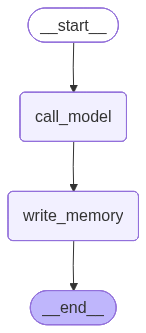

In [12]:
# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [15]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

<think>
Okay, the user introduced himself as Lance. I need to acknowledge that and offer help. Since there's no existing memory, I should keep it general. Let me make sure to use his name to personalize the response. Maybe say something like, "Hi Lance! How can I assist you today?" That should be friendly and open-ended.
</think>

Hi Lance! How can I assist you today?


In [16]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

<think>
Okay, the user mentioned they like to bike around San Francisco. Let me check the existing memory. The previous memory only had their name, Lance. Now, this is new information. I need to add that to the memory.

So, I should create a bullet point for their biking interest and location. Make sure it's concise. No other info yet, so just those two points. Need to follow the format and only include factual info. Alright, that's straightforward.
</think>

**CURRENT USER INFORMATION:**  
- **Name:** Lance  
- **Interest:** Biking around San Francisco


In [17]:
# Checking the Chat History thread
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

<think>
Okay, the user introduced himself as Lance. I need to acknowledge that and offer help. Since there's no existing memory, I should keep it general. Let me make sure to use his name to personalize the response. Maybe say something like, "Hi Lance! How can I assist you today?" That should be friendly and open-ended.
</think>

Hi Lance! How can I assist you today?
================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

<think>
Okay, the user mentioned they like to bike around San Francisco. Let me check the existing memory. The previous memory only had their

In [18]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': "<think>\nOkay, let's see. The user mentioned they like to bike around San Francisco. So I need to update the current user information with that. The existing info already has their name as Lance. The new information is their interest in biking in San Francisco.\n\nI should format this as a bulleted list. The previous entry had just the name. Now I need to add the interest. The instructions say to merge new info with existing memory. So I'll keep the name and add the new interest as a separate bullet point. Make sure it's clear and follows the formatting rules. No conflicts here since it's new info. Alright, that should do it.\n</think>\n\n**CURRENT USER INFORMATION:**  \n- **Name:** Lance  \n- **Interest:** Biking around San Francisco"},
 'created_at': '2026-02-23T12:26:33.521887+00:00',
 'updated_at': '2026-02-23T12:26:33.521892+00:00'}

In [19]:
# New Thread

# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi! Where would you recommend that I go biking?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Where would you recommend that I go biking?
================================== Ai Message ==================================

<think>
Okay, the user asked for bike recommendations. Let me check their memory. They mentioned they like to bike around San Francisco. So I should tailor the answer to SF.

First, I need to think of popular biking spots in San Francisco. Golden Gate Park is a classic. It's scenic and has dedicated bike paths. Then there's the Presidio, which offers trails with ocean views. Maybe mention the Bay Bridge as well, since the bike path there is famous and gives great city views.

I should also consider the user's possible preferences. Since they're in SF, maybe they want a mix of nature and cityscapes. Include a mix of parks and bridges. Don't forget to add a note about safety or bike rentals if they need them. Keep the recommendations friendly and helpful. Make sure to mention eac

In [20]:
# User input 
input_messages = [HumanMessage(content="Great, are there any bakeries nearby that I can check out? I like a croissant after biking.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Great, are there any bakeries nearby that I can check out? I like a croissant after biking.
================================== Ai Message ==================================

<think>
Okay, the user asked for bakeries nearby after biking in San Francisco. They mentioned liking croissants, so I should focus on places known for that. Let me recall some popular bakeries in SF.

First, I remember Tartine Bakery is a local favorite, especially for their pastries. They have a few locations. Then there's Boudin Bakery, which is historic and famous for sourdough, but maybe their pastries are good too. 

Also, maybe some newer spots like Flour + Water for their brunch and pastries. Oh, and La Boulangerie might be another one. I should check if these are in areas near the biking spots I mentioned earlier, like the Presidio or Embarcadero.

Wait, the user didn't specify a location, but since they were biking in SF, I 